In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
import keras
from functools import partial
from math import exp
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap
from tensorflow.keras.models import load_model
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

2025-06-09 12:57:44.991888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749473865.198292      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749473865.255521      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Importing processed logmelspectrograms as stored previously

In [ ]:
melspec_directory = '/kaggle/input/birdcall-melspec'
import h5py
import numpy as np
from sklearn.preprocessing import LabelEncoder
def load_from_hdf5(filename, directory):
    """Load data from HDF5 file"""
    filepath = os.path.join(directory, filename)
    with h5py.File(filepath, 'r') as hf:
        data = {name: hf[name][:] for name in hf.keys()}

    if 'classes' in data:
        label_encoder = LabelEncoder()
        label_encoder.classes_ = data['classes'].astype(str)
        data['label_encoder'] = label_encoder

    return data

loaded_data = load_from_hdf5('mfcc_data.h5', melspec_directory)

X = loaded_data['X_train']
y = loaded_data['y_train']
label_encoder = loaded_data['label_encoder']

original_labels = label_encoder.inverse_transform(y)


In [ ]:
#Model parameter definitions 
NCLASS=11
input_shape = X_train.shape[1:]
LEARNING_RATE= 0.002

# Class weightage in processed arrays

Same distribution carries to validation and test sets because of the stratified splitting

In [4]:
from collections import Counter
class_counts = Counter(original_labels)
total_samples = len(original_labels)
class_info = []

for class_name, count in class_counts.items():
    percentage = (count / total_samples) * 100
    class_info.append({
        'Class Name': class_name,
        'Samples': count,
        'Weightage (%)': percentage
    })

# Sort by class name for better readability
class_info.sort(key=lambda x: x['Class Name'])

# Print the table
print("{:<30} {:<15} {:<15}".format('Class Name', 'Samples', 'Weightage (%)'))
print("-" * 60)
for info in class_info:
    print("{:<30} {:<15} {:<15.2f}".format(
        info['Class Name'], 
        info['Samples'], 
        info['Weightage (%)']
    ))

# Print summary
print("\nSummary:")
print(f"Total number of classes: {len(class_counts)}")
print(f"Total number of samples: {total_samples}")

Class Name                     Samples         Weightage (%)  
------------------------------------------------------------
barswa                         7149            7.85           
comrav                         8941            9.82           
eursta                         13118           14.40          
gbwwre1                        5944            6.53           
houspa                         8847            9.71           
houwre                         8083            8.88           
norcar                         9248            10.15          
others                         7376            8.10           
redcro                         7391            8.12           
sonspa                         7902            8.68           
spotow                         7072            7.77           

Summary:
Total number of classes: 11
Total number of samples: 91071


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

Manual control on model layer outputs

In [6]:
class ModelInspector:
    def __init__(self, model):
        self.model = model
        self.layer_dict = {layer.name: layer for layer in model.layers}

    def get_layer_output(self, layer_name, data):

        intermediate_model = tf.keras.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer(layer_name).output
        )
        return intermediate_model.predict(data)

    def list_layers(self):

        for idx, layer in enumerate(self.model.layers):
            print(f"Layer {idx}: {layer.name} ({layer.__class__.__name__})")

In [ ]:
# Compiler parameters defintion
EPOCHS = 100
BATCH_SIZE = 128
PATIENCE = 35
LEARNING_RATE = 0.001

# Building high performing teacher model

A residual Convolutional Neural Network architecture is chosen for the teacher model.
Callbacks based on validation accuracy is implemented along with gradient clipping.

In [ ]:
dimport tensorflow as tf
from tensorflow.keras import layers, Model

def build_residual_model(input_shape, NCLASS, loss="sparse_categorical_crossentropy",
                       learning_rate=0.001, clipnorm=1.0, clipvalue=0.5):
    """Build a deep CNN with residual connections matching the shown architecture"""
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Initial Conv Block
    x = layers.Conv2D(64, (3,3), padding='same', name="conv1_1")(inputs)
    x = layers.BatchNormalization(name="bn1_1")(x)
    x = layers.ReLU(name="relu1_1")(x)
    x = layers.Conv2D(64, (3,3), padding='same', name="conv1_2")(x)
    x = layers.BatchNormalization(name="bn1_2")(x)
    x = layers.ReLU(name="relu1_2")(x)
    x = layers.MaxPooling2D((2,2), name="pool1")(x)

    # First Residual Block
    residual = layers.Conv2D(128, (1,1), strides=(2,2), padding='same', name="res1_conv")(x)
    x = layers.Conv2D(128, (3,3), padding='same', name="conv2_1")(x)
    x = layers.BatchNormalization(name="bn2_1")(x)
    x = layers.ReLU(name="relu2_1")(x)
    x = layers.Conv2D(128, (3,3), padding='same', name="conv2_2")(x)
    x = layers.BatchNormalization(name="bn2_2")(x)
    x = layers.MaxPooling2D((2,2), name="pool2")(x)
    x = layers.add([x, residual], name="res1_add")
    x = layers.ReLU(name="relu2_2")(x)

    # Second Residual Block
    residual = layers.Conv2D(256, (1,1), strides=(2,2), padding='same', name="res2_conv")(x)
    x = layers.Conv2D(256, (3,3), padding='same', name="conv3_1")(x)
    x = layers.BatchNormalization(name="bn3_1")(x)
    x = layers.ReLU(name="relu3_1")(x)
    x = layers.Conv2D(256, (3,3), padding='same', name="conv3_2")(x)
    x = layers.BatchNormalization(name="bn3_2")(x)
    x = layers.MaxPooling2D((2,2), name="pool3")(x)
    x = layers.add([x, residual], name="res2_add")
    x = layers.ReLU(name="relu3_2")(x)

    # Final Feature Processing
    x = layers.GlobalAveragePooling2D(name="gap_final")(x)
    
    # Dense Layers
    x = layers.Dense(1024, activation='relu', name="dense1")(x)
    x = layers.Dropout(0.5, name="dropout1")(x)
    x = layers.Dense(512, activation='relu', name="dense2")(x)
    x = layers.Dense(256, activation='relu', name="dense3")(x)
    x = layers.Dropout(0.3, name="dropout2")(x)
    x = layers.Dense(128, activation='relu', name="dense4")(x)
    
    outputs = layers.Dense(NCLASS, activation='softmax', name="output_layer")(x)

    # Model Compilation
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        clipnorm=clipnorm,
        clipvalue=clipvalue
    )
    
    model.compile(optimizer=optimizer, 
                 loss=loss, 
                 metrics=["accuracy"])
    return model

# Model initialization
NCLASS = 11
input_shape = (47, 64, 1)  # Matching your input shape from the summary
model = build_residual_model(input_shape, NCLASS)
model.summary()

# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/teacher.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Model training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

In [8]:
model_path = '/kaggle/input/teacher/keras/default/1/teacher.keras'
teacher_model = load_model(model_path)

I0000 00:00:1749411685.422840      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Evaluating on test set

In [9]:
y_pred = teacher_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

test_loss, test_acc = teacher_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

I0000 00:00:1749411688.503178      96 service.cc:148] XLA service 0x78bd6c00e760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749411688.505458      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749411688.697610      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


 36/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

I0000 00:00:1749411690.510063      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step

Test Accuracy: 0.9493
Test Loss: 0.3213


# Classification report and t-SNE analysis

The detailed performance report of the teacher model is provided through a comfusion matrix. The cluster seperability of the classes after processing in the final Global Average Pooling layer is analyzed through 2 dimensional t-SNE plot.

              precision    recall  f1-score   support

      barswa       0.96      0.95      0.95       357
      comrav       0.98      0.95      0.97       447
      eursta       0.95      0.97      0.96       656
     gbwwre1       0.96      0.96      0.96       297
      houspa       0.97      0.97      0.97       443
      houwre       0.93      0.95      0.94       404
      norcar       0.96      0.95      0.96       463
      others       0.86      0.89      0.87       369
      redcro       0.97      0.97      0.97       370
      sonspa       0.94      0.92      0.93       395
      spotow       0.95      0.95      0.95       353

    accuracy                           0.95      4554
   macro avg       0.95      0.95      0.95      4554
weighted avg       0.95      0.95      0.95      4554



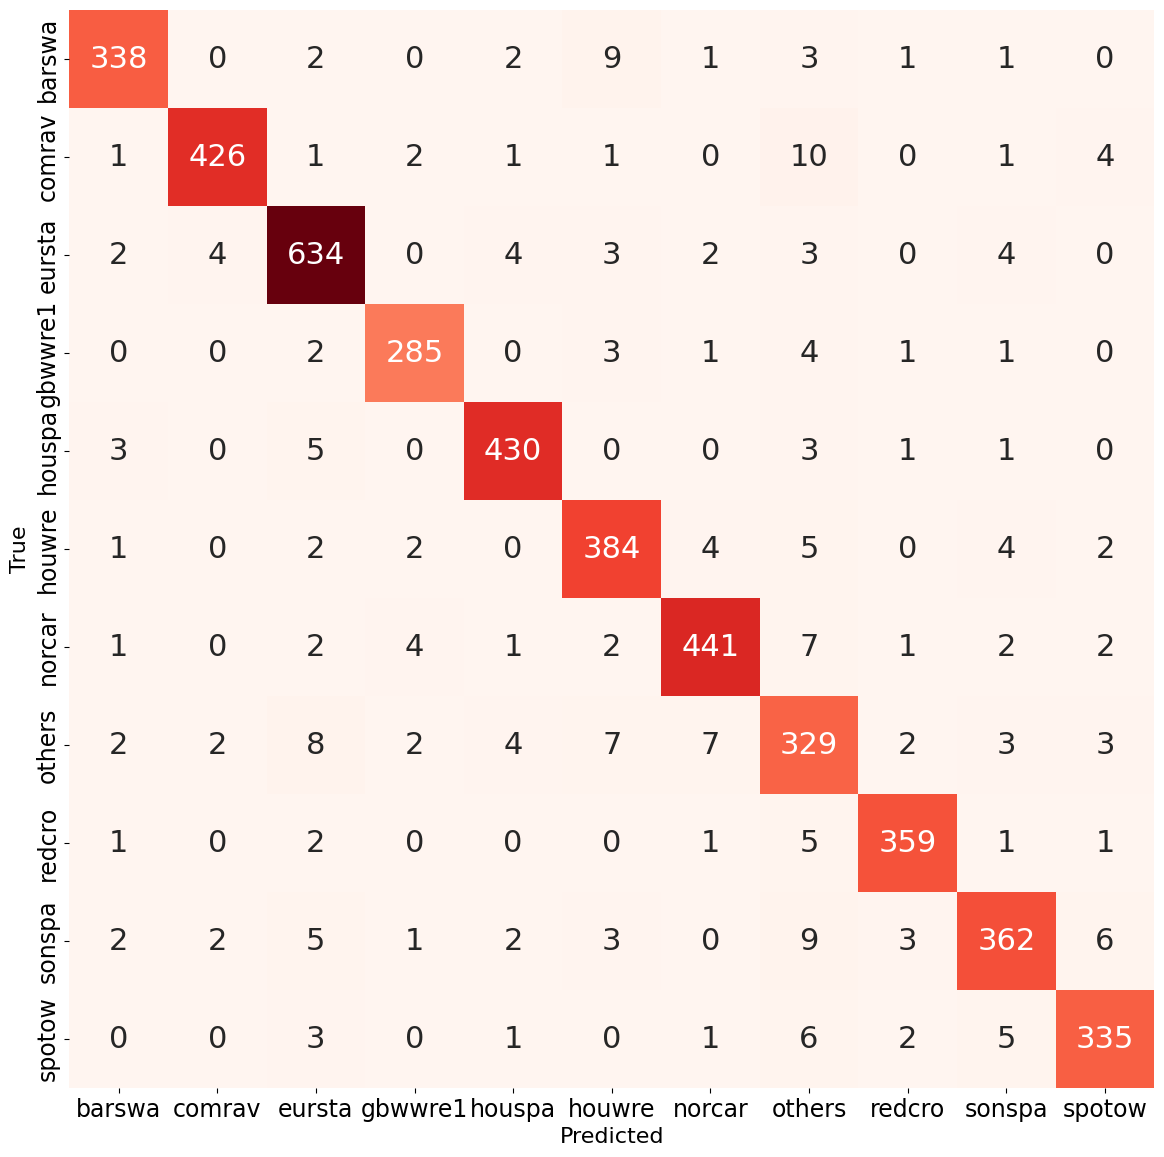


Balanced Accuracy: 0.9479
Macro F1 Score: 0.9483


In [17]:
### print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# 5. Confusion matrix with larger numbers
plt.figure(figsize=(14, 14))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar=False,
            annot_kws={"size": 22})  # Increase the font size here
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
#plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('/kaggle/working/confusion matrix.png', bbox_inches='tight')
plt.show()

# 6. Additional metrics (for multi-class)
from sklearn.metrics import balanced_accuracy_score, f1_score
print(f"\nBalanced Accuracy: {balanced_accuracy_score(y_test, y_pred_classes):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_classes, average='macro'):.4f}")

In [15]:
gap_features = ModelInspector(teacher_model).get_layer_output('gap_final', X_train)

if len(gap_features) > 10000:
    sample_idx = np.random.choice(len(gap_features), 10000, replace=False)
    features_sample = gap_features[sample_idx]
    y_sample = y_train[sample_idx]
else:
    features_sample = gap_features
    y_sample = y_train

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features_sample)

unique_classes = np.unique(y_sample)

2562/2562 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


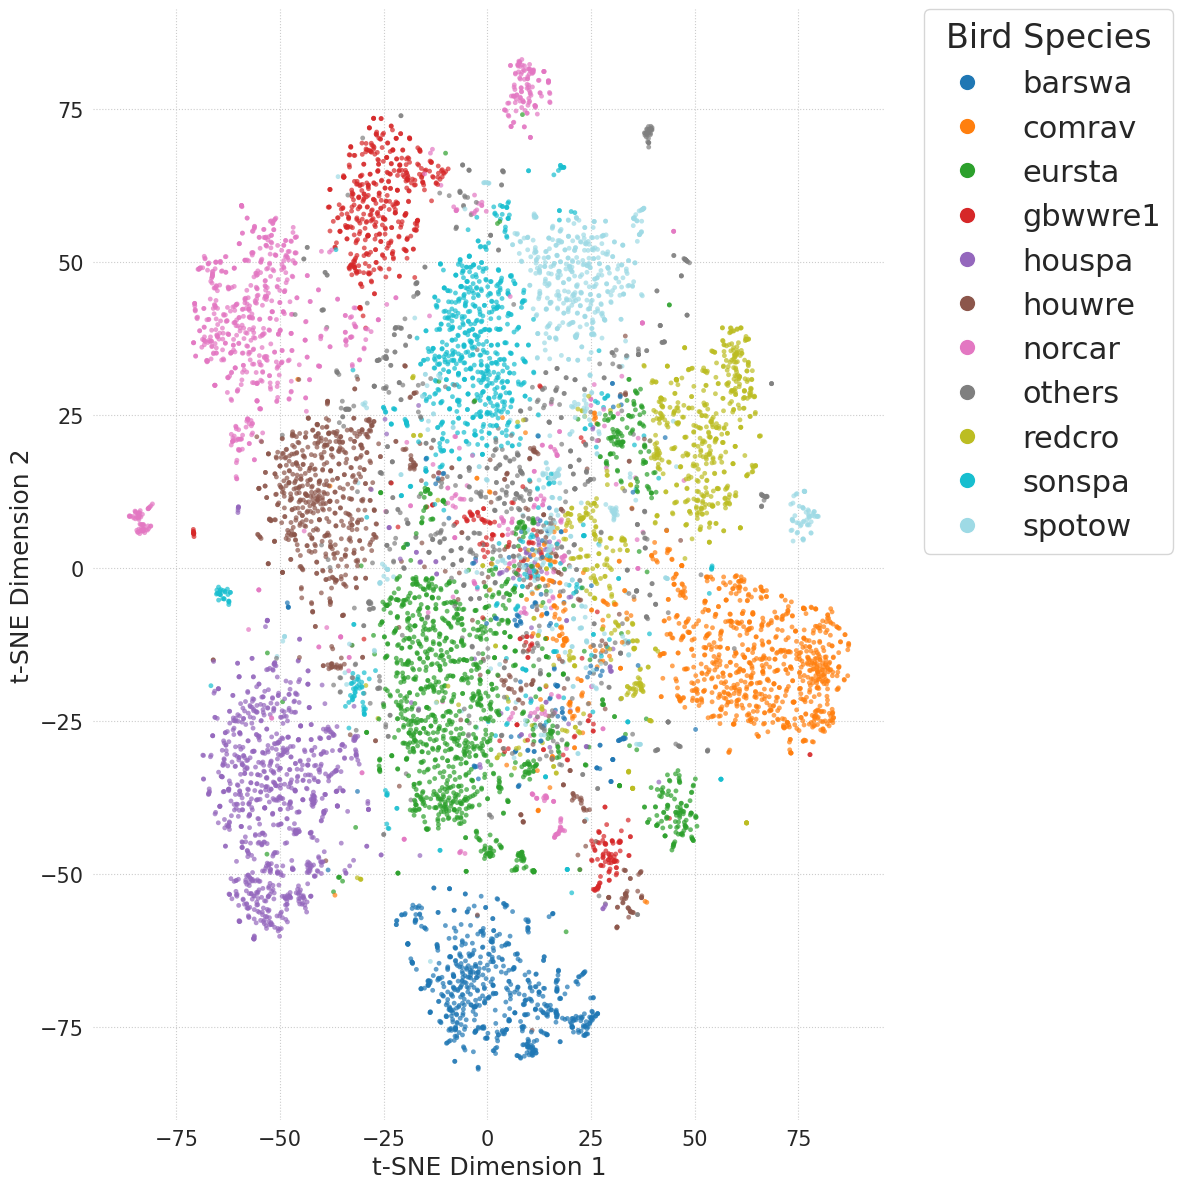

In [22]:
plt.figure(figsize=(12, 12))
sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.8'})

scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                     c=y_sample, cmap='tab20',
                     s=12, alpha=0.7,
                     edgecolors='none')

# Create custom legend
unique_classes = np.unique(y_sample)
colors = [scatter.cmap(scatter.norm(cls)) for cls in unique_classes]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                  label=label_encoder.classes_[cls],
                  markerfacecolor=color, markersize=12)
                  for cls, color in zip(unique_classes, colors)]

legend=plt.legend(handles=legend_elements,
          title="Bird Species",
          
          bbox_to_anchor=(1.05, 1),
          borderaxespad=0.,
          frameon=True,
          fontsize=22)
legend.get_title().set_fontsize(24)

#plt.title('t-SNE Visualization of Learned Bird Features', fontsize=14, pad=20)
plt.xlabel('t-SNE Dimension 1', fontsize=18)
plt.ylabel('t-SNE Dimension 2', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('/kaggle/working/feature_GAP.png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np


def evaluate_cluster_separability(embeddings, true_labels):
    """Calculate cluster metrics for t-SNE results"""
    print("\nCluster Separability Evaluation")
    print("="*50)
    
    # 1. Using TRUE class labels as clusters
    print("\nMetrics using TRUE CLASS LABELS as clusters:")
    print(f"Number of classes: {len(np.unique(true_labels))}")
    
    sil_score = silhouette_score(embeddings, true_labels)
    ch_score = calinski_harabasz_score(embeddings, true_labels)
    db_score = davies_bouldin_score(embeddings, true_labels)
    
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.1f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
    
    # 2. Using k-means clustering on t-SNE results
    from sklearn.cluster import KMeans
    k = len(np.unique(true_labels))  # Using true number of classes
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    print("\nMetrics using K-MEANS CLUSTERING on t-SNE:")
    sil_score = silhouette_score(embeddings, cluster_labels)
    ch_score = calinski_harabasz_score(embeddings, cluster_labels)
    db_score = davies_bouldin_score(embeddings, cluster_labels)
    
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.1f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")
    
    print("="*50)
    return cluster_labels  # Return the k-means cluster assignments

# Usage with your t-SNE results
cluster_labels = evaluate_cluster_separability(tsne_result, y_sample)

NameError: name 'tsne_result' is not defined

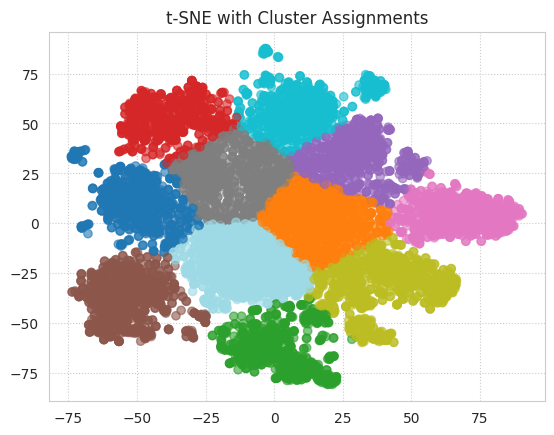

In [25]:
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=cluster_labels, cmap='tab20', alpha=0.6)
plt.title('t-SNE with Cluster Assignments')
plt.show()